<a href="https://colab.research.google.com/github/SylGrafe/RepoDl04/blob/master/lab2_M00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

lab2_M00 
reference pgm from
6.3-advanced-usage-of-recurrent-neural-networks

See lab2Sygr0003.pdf for instructions and comments


Using TensorFlow backend.


Cloning into 'RepoDl04'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 38 (delta 19), reused 29 (delta 10), pack-reused 0
Unpacking objects: 100% (38/38), done.
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


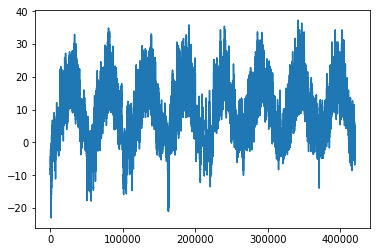

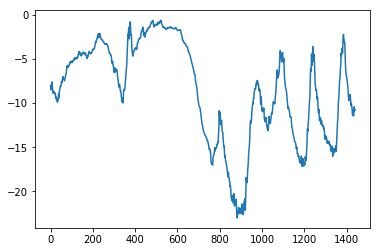

'\n# ## A common sense, non-machine learning baseline\n# \n# \nBefore we start leveraging black-box deep learning models to solve our \ntemperature prediction problem, let\'s try out a simple common-sense \napproach. It will serve as a sanity check, and it will establish a baseline \nthat we will have to beat in order to demonstrate the \nusefulness of more advanced machine learning models. \nSuch common-sense baselines can be very useful when approaching a new problem \nfor  which there is no known solution (yet). A classic example is that of\nunbalanced classification tasks, where some classes can be much more \n# common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to \n# the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, \n# and any learning-based approach should therefore beat this 90% score in order to demonstrate

In [0]:
#!/usr/bin/env python
# coding: utf-8
# from 6.3-advanced-usage-of-recurrent-neural-networks.py
#  study data  + simply fully-connected model  and baseline
import keras
keras.__version__
import os

"""
weather forecasting problem, where we have access to a timeseries of data 
points coming from sensors   installed on the roof of a building, such as
temperature, air pressure, and humidity, which we use to predict what the 
temperature will be   24 hours after the last data point collected. 

Here is a simply fully-connected model in which we start by flattening the 
data, then run it through two `Dense` layers. Note the lack of 
# activation function on the last `Dense` layer, which is typical for a 
regression problem. We use MAE as the loss. Since we are evaluating 
 on the exact same data and with the exact same metric as with our common 
sense approach, the results will be directly comparable.
"""

doRunLocal = False
if doRunLocal:
  data_dir = '/home/syl1/doNotBackup/RepoDl04' 
else:
  !git clone https://github.com/SylGrafe/RepoDl04.git
  data_dir = 'RepoDl04'

fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))


# Let's convert all of these 420,551 lines of data into a Numpy array:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


# For instance, here is the plot of temperature (in degrees Celsius) over time:

from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

"""
On this plot, you can clearly see the yearly periodicity of temperature.
Here is a more narrow plot of the first ten days of temperature data
(since the data is recorded every ten minutes, we get 144 data points 
per day):
"""
plt.plot(range(1440), temp[:1440])
plt.show()


"""
On this plot, you can see daily periodicity, especially evident for the 
last 4 days. We can also note that this ten-days period must be 
coming from a fairly cold winter month.

 
If we were trying to predict average temperature for the next month given a 
few month of past data, the problem would be easy, due to the 
reliable year-scale periodicity of the data. But looking at the data over a 
scale of days, the temperature looks a lot more chaotic. So is 
this timeseries predictable at a daily scale? Let's find out.


Preparing the data

The exact formulation of our problem will be the following: given data going 
as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in
`delay` timesteps?

We will use the following parameter values:
# 
# * `lookback = 720`, i.e. our observations will go back 5 days.
# * `steps = 6`, i.e. our observations will be sampled at one data point per hour.
# * `delay = 144`, i.e. our targets will be 24 hours in the future.
# 
# To get started, we need to do two things:
# 
# * Preprocess the data to a format a neural network can ingest. This is easy: 
the data is already numerical, so we don't need to do any 
# vectorization. However each timeseries in the data is on a different scale 
(e.g. temperature is typically between -20 and +30, but 
# pressure, measured in mbar, is around 1000). So we will normalize each 
timeseries independently so that they all take small values on a 
# similar scale.
# * Write a Python generator that takes our current array of float data and 
yields batches of data from the recent past, alongside with a 
# target temperature in the future. Since the samples in our dataset are highly
redundant (e.g. sample `N` and sample `N + 1` will have most 
# of their timesteps in common), it would be very wasteful to explicitly 
allocate every sample. Instead, we will generate the samples on the 
# fly using the original data.
# 
# We preprocess the data by subtracting the mean of each timeseries and 
dividing by the standard deviation. We plan on using the first 
# 200,000 timesteps as training data, so we compute the mean and standard 
deviation only on this fraction of the data:
"""

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


""" 
Now here is the data generator that we will use. It yields a tuple `(samples, 
targets)` where `samples` is one batch of input data and  `targets` is the corresponding array of target temperatures. It takes the 
following arguments:
 
* `data`: The original array of floating point data, which we just 
normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which t
imesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 
in order to draw one data point every hour.
"""

# lookback // step == nb of valid samples to consider for learning
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


"""
# Now let's use our abstract generator function to instantiate three generators
, one for training, one for validation and one for testing. 
# Each will look at different temporal segments of the original data: the
training generator looks at the first 200,000 timesteps, the 
# validation generator looks at the following 100,000, and the test generator 
looks at the remainder.
"""
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

"""
# ## A common sense, non-machine learning baseline
# 
# 
Before we start leveraging black-box deep learning models to solve our 
temperature prediction problem, let's try out a simple common-sense 
approach. It will serve as a sanity check, and it will establish a baseline 
that we will have to beat in order to demonstrate the 
usefulness of more advanced machine learning models. 
Such common-sense baselines can be very useful when approaching a new problem 
for  which there is no known solution (yet). A classic example is that of
unbalanced classification tasks, where some classes can be much more 
# common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to 
# the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, 
# and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary 
# baseline can prove surprisingly hard to beat.
# 
# In our case, the temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the 
# temperatures today) as well as periodical with a daily period. 
Thus a common sense approach would be to always predict that the temperature 
# 24 hours from now will be equal to the temperature right now.
Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 
# Mean Absolute Error is simply equal to:
"""



# Here's our evaluation loop:




In [0]:


def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()





0.2897359729905486


In [0]:
print ("float_data.shape" , float_data.shape)
# never forget to break out of a train_generator
for data_batch, labels_batch in train_gen:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

ind=1 
ind1=0
print ("one unit in one previousUnitsList" , data_batch[ind][ind1])       
print ("target for one previousUnitsList" , labels_batch[ind])    


float_data.shape (420551, 14)
data batch shape: (128, 240, 14)
labels batch shape: (128,)
one unit in one previousUnitsList [-0.01254168 -0.48430945 -0.48097812 -0.29424943  0.5228538  -0.62203989
 -0.49235711 -0.56110001 -0.4933924  -0.49275134  0.43154161 -0.53427648
 -0.80213276  0.41198055]
target for one previousUnitsList -2.256690315863314


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 1.2508 - val_loss: 0.6043
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4372 - val_loss: 0.3868
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2989 - val_loss: 0.3491
Epoch 4/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2673 - val_loss: 0.2984
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2542 - val_loss: 0.3104
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2437 - val_loss: 0.3002
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2344 - val_loss: 0.3261
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2306 - val_loss: 0.3403
Epoch 9/20
500/500 [==============================] - 11s 21ms/s

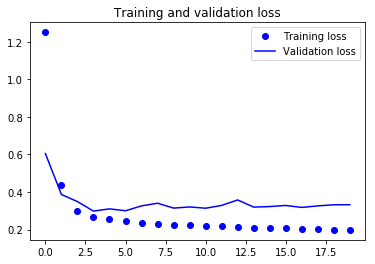

In [0]:

"""
# It yields a MAE of 0.29. Since our temperature data has been normalized to
be centered on 0 and have a standard deviation of one, this 
# number is not immediately interpretable. It translates to an average absolute
error of `0.29 * temperature_std` degrees Celsius, i.e. 
# 2.57˚C. That's a fairly large average absolute error -- now the game is to
leverage		 our knowledge of deep learning to do better. 

# ## A basic machine learning approach
# 
# In the same way that it is useful to establish a common sense baseline
before trying machine learning approaches, it is useful to try 
# simple and cheap machine learning models (such as small densely-connected
networks) before looking into complicated and computationally 
# expensive models such as RNNs. This is the best way to make sure that 
any further complexity we throw at the problem later on is legitimate 
# and delivers real benefits.
# 
"""

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




# 
# Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
# common sense contains already a lot of valuable information that a machine learning model does not have access to.
# 
# You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
# the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
# for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
# with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
# complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
# is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
# of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.







end notebook